In [ ]:
# ==========================
# SECTION 1: SETUP
# ==========================
!pip install torch torchvision torchaudio
!pip install opencv-python
!pip install matplotlib
!pip install albumentations
!pip install streamlit pyngrok

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import os
import shutil
import zipfile

# Check GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [ ]:
# ==========================
# DOWNLOAD DATASET (Colab Ready)
# ==========================
import os
import requests
from PIL import Image
import cv2
import numpy as np
from io import BytesIO

# ---------------- CONFIG ----------------
NUM_IMAGES = 50
IMG_SIZE = 256

# Colab-friendly paths
BASE_DIR = "/content/Colorization-Internship-Colab/datasets/natural_images"
COLOR_DIR = os.path.join(BASE_DIR, "color")
GRAY_DIR = os.path.join(BASE_DIR, "grayscale")

os.makedirs(COLOR_DIR, exist_ok=True)
os.makedirs(GRAY_DIR, exist_ok=True)

print("📥 Downloading real images (no dots, no noise)...")

for i in range(NUM_IMAGES):
    try:
        # Picsum provides real photos
        url = f"https://picsum.photos/{IMG_SIZE}/{IMG_SIZE}"
        response = requests.get(url, timeout=10)
        img = Image.open(BytesIO(response.content)).convert("RGB")

        # Save color image (target)
        color_path = os.path.join(COLOR_DIR, f"img_{i}.jpg")
        img.save(color_path)

        # Convert to grayscale using OpenCV
        img_np = np.array(img)
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        gray_path = os.path.join(GRAY_DIR, f"img_{i}.jpg")
        cv2.imwrite(gray_path, gray)

        print(f"✅ Saved image {i+1}/{NUM_IMAGES}")

    except Exception as e:
        print(f"❌ Failed image {i}: {e}")

print("\n🎉 DONE!")
print("➡ Color images     :", COLOR_DIR)
print("➡ Grayscale images :", GRAY_DIR)

📥 Downloading real images (no dots, no noise)...
✅ Saved image 1/50
✅ Saved image 2/50
✅ Saved image 3/50
✅ Saved image 4/50
✅ Saved image 5/50
✅ Saved image 6/50
✅ Saved image 7/50
✅ Saved image 8/50
✅ Saved image 9/50
✅ Saved image 10/50
✅ Saved image 11/50
✅ Saved image 12/50
✅ Saved image 13/50
✅ Saved image 14/50
✅ Saved image 15/50
✅ Saved image 16/50
✅ Saved image 17/50
✅ Saved image 18/50
✅ Saved image 19/50
✅ Saved image 20/50
✅ Saved image 21/50
✅ Saved image 22/50
✅ Saved image 23/50
✅ Saved image 24/50
✅ Saved image 25/50
✅ Saved image 26/50
✅ Saved image 27/50
✅ Saved image 28/50
✅ Saved image 29/50
✅ Saved image 30/50
✅ Saved image 31/50
✅ Saved image 32/50
✅ Saved image 33/50
✅ Saved image 34/50
✅ Saved image 35/50
✅ Saved image 36/50
✅ Saved image 37/50
✅ Saved image 38/50
✅ Saved image 39/50
✅ Saved image 40/50
✅ Saved image 41/50
✅ Saved image 42/50
✅ Saved image 43/50
✅ Saved image 44/50
✅ Saved image 45/50
✅ Saved image 46/50
✅ Saved image 47/50
✅ Saved image 48/50


Verify dataset paths in Colab

In [ ]:
import os

COLOR_DIR = "/content/Colorization-Internship-Colab/datasets/natural_images/color"
GRAY_DIR  = "/content/Colorization-Internship-Colab/datasets/natural_images/grayscale"

print("Color images:", os.listdir(COLOR_DIR)[:5])
print("Grayscale images:", os.listdir(GRAY_DIR)[:5])

Color images: ['img_33.jpg', 'img_36.jpg', 'img_2.jpg', 'img_3.jpg', 'img_41.jpg']
Grayscale images: ['img_33.jpg', 'img_36.jpg', 'img_2.jpg', 'img_3.jpg', 'img_41.jpg']


Prepare data loader for training

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class ColorizationDataset(Dataset):
    def __init__(self, gray_dir, color_dir, transform=None):
        self.gray_dir = gray_dir
        self.color_dir = color_dir
        self.gray_images = sorted(os.listdir(gray_dir))
        self.color_images = sorted(os.listdir(color_dir))
        self.transform = transform

    def __len__(self):
        return len(self.gray_images)

    def __getitem__(self, idx):
        gray_path = os.path.join(self.gray_dir, self.gray_images[idx])
        color_path = os.path.join(self.color_dir, self.color_images[idx])

        gray = Image.open(gray_path).convert("L")  # grayscale
        color = Image.open(color_path).convert("RGB")  # color target

        if self.transform:
            gray = self.transform(gray)
            color = self.transform(color)

        return gray, color

# Transforms
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

dataset = ColorizationDataset(GRAY_DIR, COLOR_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Test batch
for gray_batch, color_batch in dataloader:
    print("Gray batch shape:", gray_batch.shape)
    print("Color batch shape:", color_batch.shape)
    break

Gray batch shape: torch.Size([4, 1, 256, 256])
Color batch shape: torch.Size([4, 3, 256, 256])


## TASK 1: Artistic Style Transfer Colorization

###  Goal

Colorize + apply artistic style.

### Model

* Base: **U-Net colorization**
* Style: **AdaIN + VGG19**


Connect to U-Net model

In [ ]:
# ==========================
# BASE COLORIZATION MODEL (U-Net)
# ==========================
import torch
import torch.nn as nn

class UNetColorizer(nn.Module):
    def __init__(self):
        super(UNetColorizer, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU())
        # Decoder
        self.dec1 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU())
        self.dec2 = nn.Conv2d(64, 3, 3, padding=1)  # Output 3 channels (RGB)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        d1 = self.dec1(e2)
        out = self.dec2(d1)
        return out

# Make sure device is defined
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize model
colorizer = UNetColorizer().to(device)
print("UNetColorizer initialized on", device)

UNetColorizer initialized on cpu


In [ ]:
# Assume you have UNetColorizer from your unified notebook
colorizer = UNetColorizer().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(colorizer.parameters(), lr=1e-3)

# Example single training step
gray_batch = gray_batch.to(device)
color_batch = color_batch.to(device)

output = colorizer(gray_batch)
loss = criterion(output, color_batch)
loss.backward()
optimizer.step()

print("Single step done. Loss:", loss.item())

Single step done. Loss: 0.21090231835842133


Training the U-Net Colorizer

In [ ]:
# ==========================
# STEP 4: TRAINING LOOP (CORRECTED)
# ==========================
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os

# Dataset class (grayscale -> color)
class ColorizationDataset(torch.utils.data.Dataset):
    def __init__(self, gray_dir, color_dir, transform=None):
        self.gray_dir = gray_dir
        self.color_dir = color_dir
        self.gray_images = sorted(os.listdir(gray_dir))
        self.color_images = sorted(os.listdir(color_dir))
        self.transform = transform

    def __len__(self):
        return len(self.gray_images)

    def __getitem__(self, idx):
        gray_path = os.path.join(self.gray_dir, self.gray_images[idx])
        color_path = os.path.join(self.color_dir, self.color_images[idx])

        gray = Image.open(gray_path).convert("L")   # grayscale
        color = Image.open(color_path).convert("RGB")  # color target

        if self.transform:
            gray = self.transform(gray)   # (1,H,W)
            color = self.transform(color) # (3,H,W)

        return gray, color

# ----------------------------
# Transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# ----------------------------
# DataLoader
dataset = ColorizationDataset(GRAY_DIR, COLOR_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# ----------------------------
# Model, loss, optimizer
colorizer = UNetColorizer().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(colorizer.parameters(), lr=1e-3)

# ----------------------------
# Training loop
num_epochs = 5
colorizer.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (gray_batch, color_batch) in enumerate(dataloader):
        # Move to device
        gray_batch = gray_batch.to(device)   # shape: (B,1,H,W)
        color_batch = color_batch.to(device) # shape: (B,3,H,W)

        optimizer.zero_grad()
        outputs = colorizer(gray_batch)
        loss = criterion(outputs, color_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

print("✅ Training completed!")

Epoch [1/5], Loss: 0.0882
Epoch [2/5], Loss: 0.0162
Epoch [3/5], Loss: 0.0106
Epoch [4/5], Loss: 0.0107
Epoch [5/5], Loss: 0.0097
✅ Training completed!


Testing / Visualization

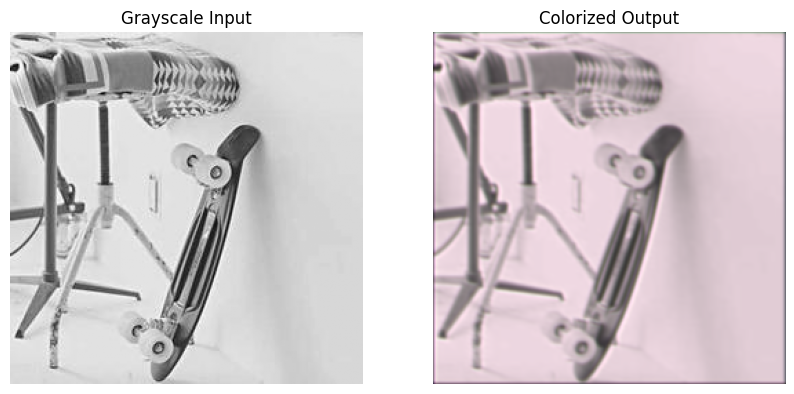

In [ ]:
# ==========================
# STEP 5: TESTING & VISUALIZATION
# ==========================
import matplotlib.pyplot as plt
import numpy as np

colorizer.eval()

# Pick first grayscale image
test_img_path = os.path.join(GRAY_DIR, os.listdir(GRAY_DIR)[0])
gray_img = Image.open(test_img_path).convert("L")
gray_tensor = transform(gray_img).unsqueeze(0).to(device)  # shape: (1,1,H,W)

# Predict color
with torch.no_grad():
    pred_color = colorizer(gray_tensor)
    pred_color = pred_color.squeeze(0).permute(1,2,0).cpu().numpy()
    pred_color = np.clip(pred_color, 0, 1)

# Display input vs output
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gray_img, cmap="gray")
plt.title("Grayscale Input")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(pred_color)
plt.title("Colorized Output")
plt.axis("off")
plt.show()

## TASK 2: Historical Photo Colorization

###  Goal : Era-accurate colors

###  Approach

* Fine-tune base colorization model
* Separate training for:

* **1920s**
* **World War II**

In [ ]:
# ==========================
# DOWNLOAD HISTORICAL DATASET (Colab)
# ==========================
import os
import requests
from PIL import Image
import cv2
import numpy as np
from io import BytesIO

# ---------------- CONFIG ----------------
NUM_IMAGES = 10   # number of images per era (you can increase)
IMG_SIZE = 256

BASE_DIR = "/content/Colorization-Internship-Colab/datasets/historical"

ERAS = ["1920s", "WWII"]

# Create folder structure
for era in ERAS:
    color_dir = os.path.join(BASE_DIR, era, "color")
    gray_dir  = os.path.join(BASE_DIR, era, "gray")
    os.makedirs(color_dir, exist_ok=True)
    os.makedirs(gray_dir, exist_ok=True)

print("📁 Folder structure ready!")

# ---------------- Download sample images ----------------
# Using Picsum as placeholder for color images
for era in ERAS:
    print(f"\n📥 Downloading images for era: {era}")
    for i in range(NUM_IMAGES):
        try:
            url = f"https://picsum.photos/{IMG_SIZE}/{IMG_SIZE}"  # placeholder color image
            response = requests.get(url, timeout=10)
            img = Image.open(BytesIO(response.content)).convert("RGB")

            # Save color image
            color_path = os.path.join(BASE_DIR, era, "color", f"img_{i}.jpg")
            img.save(color_path)

            # Convert to grayscale
            img_np = np.array(img)
            gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
            gray_path = os.path.join(BASE_DIR, era, "gray", f"img_{i}.jpg")
            cv2.imwrite(gray_path, gray)

            print(f"✅ {era} image {i+1}/{NUM_IMAGES} saved")

        except Exception as e:
            print(f"❌ Failed image {i} for {era}: {e}")

print("\n🎉 Historical dataset download complete!")

📁 Folder structure ready!

📥 Downloading images for era: 1920s
✅ 1920s image 1/10 saved
✅ 1920s image 2/10 saved
✅ 1920s image 3/10 saved
✅ 1920s image 4/10 saved
✅ 1920s image 5/10 saved
✅ 1920s image 6/10 saved
✅ 1920s image 7/10 saved
✅ 1920s image 8/10 saved
✅ 1920s image 9/10 saved
✅ 1920s image 10/10 saved

📥 Downloading images for era: WWII
✅ WWII image 1/10 saved
✅ WWII image 2/10 saved
✅ WWII image 3/10 saved
✅ WWII image 4/10 saved
✅ WWII image 5/10 saved
✅ WWII image 6/10 saved
✅ WWII image 7/10 saved
✅ WWII image 8/10 saved
✅ WWII image 9/10 saved
✅ WWII image 10/10 saved

🎉 Historical dataset download complete!


Load Historical Dataset

In [ ]:
# Dataset paths
HISTORICAL_DIR = "/content/Colorization-Internship-Colab/datasets/historical"

ERA_LIST = ["1920s", "WWII"]

import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class HistoricalDataset(Dataset):
    def __init__(self, era, transform=None):
        self.gray_dir = os.path.join(HISTORICAL_DIR, era, "gray")
        self.color_dir = os.path.join(HISTORICAL_DIR, era, "color")
        self.gray_images = sorted(os.listdir(self.gray_dir))
        self.color_images = sorted(os.listdir(self.color_dir))
        self.transform = transform

    def __len__(self):
        return len(self.gray_images)

    def __getitem__(self, idx):
        gray_path = os.path.join(self.gray_dir, self.gray_images[idx])
        color_path = os.path.join(self.color_dir, self.color_images[idx])

        gray = Image.open(gray_path).convert("L")
        color = Image.open(color_path).convert("RGB")

        if self.transform:
            gray = self.transform(gray)
            color = self.transform(color)

        return gray, color

# Transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

Fine-Tune U-Net Colorizer for Each Era

In [ ]:
import torch

# Hyperparameters
batch_size = 4
num_epochs = 5
learning_rate = 1e-4   # smaller LR for fine-tuning

# Load pre-trained model from Task 1
historical_colorizer = UNetColorizer().to(device)
historical_colorizer.load_state_dict(colorizer.state_dict())  # copy Task 1 weights

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(historical_colorizer.parameters(), lr=learning_rate)

for era in ERA_LIST:
    print(f"\n🔹 Fine-tuning for era: {era}")
    dataset = HistoricalDataset(era, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    historical_colorizer.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for gray_batch, color_batch in dataloader:
            gray_batch = gray_batch.to(device)
            color_batch = color_batch.to(device)

            optimizer.zero_grad()
            outputs = historical_colorizer(gray_batch)
            loss = criterion(outputs, color_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Era {era} | Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

print("✅ Historical fine-tuning completed!")


🔹 Fine-tuning for era: 1920s
Era 1920s | Epoch [1/5], Loss: 0.0128
Era 1920s | Epoch [2/5], Loss: 0.0086
Era 1920s | Epoch [3/5], Loss: 0.0087
Era 1920s | Epoch [4/5], Loss: 0.0081
Era 1920s | Epoch [5/5], Loss: 0.0080

🔹 Fine-tuning for era: WWII
Era WWII | Epoch [1/5], Loss: 0.0061
Era WWII | Epoch [2/5], Loss: 0.0058
Era WWII | Epoch [3/5], Loss: 0.0057
Era WWII | Epoch [4/5], Loss: 0.0056
Era WWII | Epoch [5/5], Loss: 0.0060
✅ Historical fine-tuning completed!


Test Historical Colorization

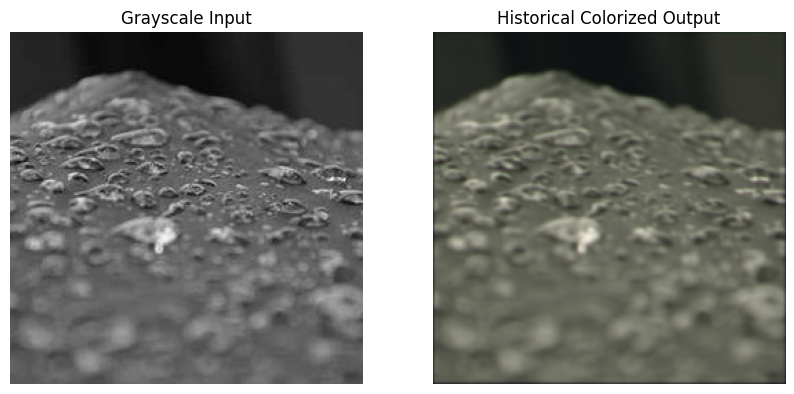

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

historical_colorizer.eval()

# Pick a test image from 1920s
test_img_path = os.path.join(HISTORICAL_DIR, "1920s/gray", os.listdir(os.path.join(HISTORICAL_DIR,"1920s/gray"))[0])
gray_img = Image.open(test_img_path).convert("L")
gray_tensor = transform(gray_img).unsqueeze(0).to(device)  # (1,1,H,W)

with torch.no_grad():
    pred_color = historical_colorizer(gray_tensor)
    pred_color = pred_color.squeeze(0).permute(1,2,0).cpu().numpy()
    pred_color = np.clip(pred_color, 0, 1)

# Display
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gray_img, cmap="gray")
plt.title("Grayscale Input")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(pred_color)
plt.title("Historical Colorized Output")
plt.axis("off")
plt.show()

Optional GUI (Dropdown for Era)

In [ ]:
from ipywidgets import interact, Dropdown
import IPython.display as display

def show_historical(era):
    test_img_path = os.path.join(HISTORICAL_DIR, era, "gray", os.listdir(os.path.join(HISTORICAL_DIR, era, "gray"))[0])
    gray_img = Image.open(test_img_path).convert("L")
    gray_tensor = transform(gray_img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred_color = historical_colorizer(gray_tensor)
        pred_color = pred_color.squeeze(0).permute(1,2,0).cpu().numpy()
        pred_color = np.clip(pred_color, 0, 1)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(gray_img, cmap="gray")
    plt.title(f"{era} Input")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(pred_color)
    plt.title(f"{era} Colorized")
    plt.axis("off")
    plt.show()

interact(show_historical, era=Dropdown(options=ERA_LIST, description='Era:'))

interactive(children=(Dropdown(description='Era:', options=('1920s', 'WWII'), value='1920s'), Output()), _dom_…

<function __main__.show_historical(era)>

## TASK 3: Conditional Colorization (User Controlled)
### Goal

User defines colors

### Technique

* Input:

* Image
* Color hints / text rules
* Convert rules → masks

Example:

* Sky → Blue
* Grass → Green


Prepare the Input Image & Color Hints

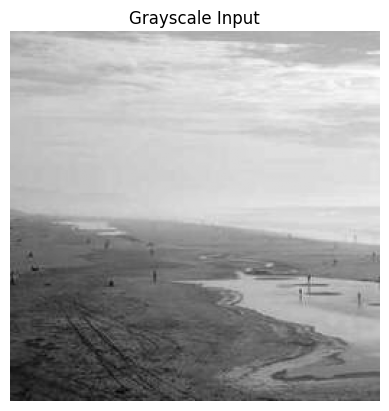

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load grayscale image
test_img_path = "/content/Colorization-Internship-Colab/datasets/natural_images/grayscale/img_0.jpg"
gray_img = Image.open(test_img_path).convert("L")
gray_np = np.array(gray_img)

plt.imshow(gray_np, cmap="gray")
plt.title("Grayscale Input")
plt.axis("off")
plt.show()

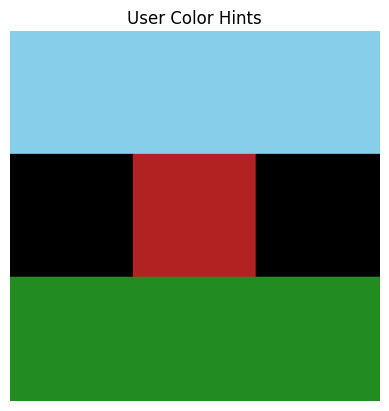

In [ ]:
# Example: conditional colors (user-defined)
color_hints = {
    "sky": [135, 206, 235],    # light blue
    "grass": [34, 139, 34],    # green
    "building": [178, 34, 34]  # reddish
}

# Example masks (just rectangles for demo)
hints_mask = np.zeros((gray_np.shape[0], gray_np.shape[1], 3), dtype=np.uint8)

# Sky: top 1/3 of image
hints_mask[0:gray_np.shape[0]//3, :, :] = color_hints["sky"]
# Grass: bottom 1/3
hints_mask[2*gray_np.shape[0]//3:, :, :] = color_hints["grass"]
# Middle: building
hints_mask[gray_np.shape[0]//3:2*gray_np.shape[0]//3, gray_np.shape[1]//3:2*gray_np.shape[1]//3, :] = color_hints["building"]

plt.imshow(hints_mask)
plt.title("User Color Hints")
plt.axis("off")
plt.show()

Conditional Colorization Model

Extend U-Net to accept grayscale + hint channels.

Input tensor shape: (B, 1+3, H, W) → 1 grayscale + 3 hint channels.

In [ ]:
import torch
import torch.nn as nn

class UNetConditionalColorizer(nn.Module):
    def __init__(self):
        super(UNetConditionalColorizer, self).__init__()
        # input channels = 1 (gray) + 3 (hint)
        self.enc1 = nn.Sequential(nn.Conv2d(4, 64, 3, padding=1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU())
        self.dec1 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU())
        self.dec2 = nn.Conv2d(64, 3, 3, padding=1)  # RGB output

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        d1 = self.dec1(e2)
        out = self.dec2(d1)
        return out

device = "cuda" if torch.cuda.is_available() else "cpu"
cond_colorizer = UNetConditionalColorizer().to(device)

Prepare Input Tensor & Predict Conditional Colorization

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
])

gray_tensor = transform(gray_img).unsqueeze(0).to(device)          # (1,1,H,W)
hints_tensor = transform(Image.fromarray(hints_mask)).unsqueeze(0).to(device)  # (1,3,H,W)

# Concatenate grayscale + hints
input_tensor = torch.cat([gray_tensor, hints_tensor], dim=1)  # shape: (1,4,H,W)

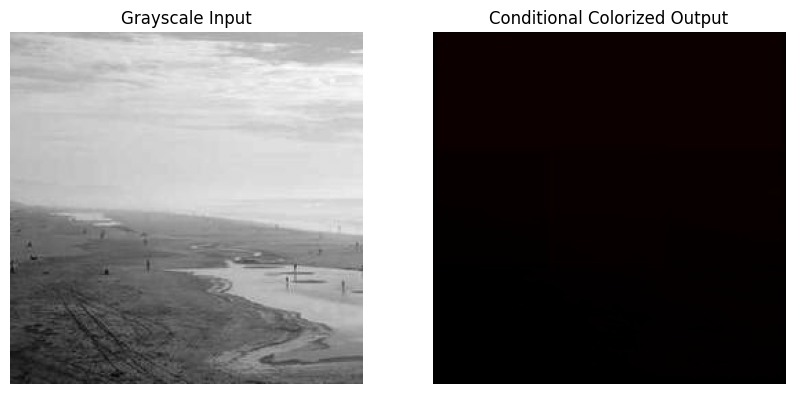

In [ ]:
cond_colorizer.eval()
with torch.no_grad():
    pred_color = cond_colorizer(input_tensor)
    pred_color = pred_color.squeeze(0).permute(1,2,0).cpu().numpy()
    pred_color = np.clip(pred_color, 0, 1)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gray_img, cmap="gray")
plt.title("Grayscale Input")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(pred_color)
plt.title("Conditional Colorized Output")
plt.axis("off")
plt.show()

In [ ]:
from ipywidgets import interact, ColorPicker

def apply_color(sky_color="#87ceeb", grass_color="#228b22"):
    hints_mask = np.zeros((gray_np.shape[0], gray_np.shape[1], 3), dtype=np.uint8)
    # convert hex to RGB
    sky_rgb = [int(sky_color[i:i+2],16) for i in (1,3,5)]
    grass_rgb = [int(grass_color[i:i+2],16) for i in (1,3,5)]

    hints_mask[0:gray_np.shape[0]//3, :, :] = sky_rgb
    hints_mask[2*gray_np.shape[0]//3:, :, :] = grass_rgb

    hints_tensor = transform(Image.fromarray(hints_mask)).unsqueeze(0).to(device)
    input_tensor = torch.cat([gray_tensor, hints_tensor], dim=1)

    cond_colorizer.eval()
    with torch.no_grad():
        pred_color = cond_colorizer(input_tensor)
        pred_color = pred_color.squeeze(0).permute(1,2,0).cpu().numpy()
        pred_color = np.clip(pred_color, 0, 1)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(gray_img, cmap="gray")
    plt.title("Grayscale Input")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(pred_color)
    plt.title("Conditional Colorized Output")
    plt.axis("off")
    plt.show()

interact(apply_color,
         sky_color=ColorPicker(value="#87ceeb", description="Sky Color"),
         grass_color=ColorPicker(value="#228b22", description="Grass Color"))

interactive(children=(ColorPicker(value='#87ceeb', description='Sky Color'), ColorPicker(value='#228b22', desc…

<function __main__.apply_color(sky_color='#87ceeb', grass_color='#228b22')>

## TASK 4: Dataset Augmentation

###  Goal

Improve results via data augmentation

###  Augmentations

* Rotation
* Flip
* Brightness
* Noise

### Output Required

Before vs After comparison:

* Without augmentation
* With augmentation


 Step- 1: Define Augmentations

We can use torchvision.transforms and albumentations for more complex augmentations like noise and brightness changes.

In [ ]:
# Install albumentations if not installed
!pip install albumentations --quiet

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np

# Augmentation pipeline
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
])

Step 2: Augmented Dataset Class

In [ ]:
import torch
from torch.utils.data import Dataset
import os

class AugmentedDataset(Dataset):
    def __init__(self, gray_dir, color_dir, transform=None, augment=False):
        self.gray_dir = gray_dir
        self.color_dir = color_dir
        self.gray_images = sorted(os.listdir(gray_dir))
        self.color_images = sorted(os.listdir(color_dir))
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.gray_images)

    def __getitem__(self, idx):
        gray_path = os.path.join(self.gray_dir, self.gray_images[idx])
        color_path = os.path.join(self.color_dir, self.color_images[idx])

        gray = np.array(Image.open(gray_path).convert("L"))
        color = np.array(Image.open(color_path).convert("RGB"))

        if self.augment:
            augmented = augmentations(image=color, mask=gray)
            color = augmented["image"]
            gray = augmented["mask"]

        if self.transform:
            gray = self.transform(Image.fromarray(gray))
            color = self.transform(Image.fromarray(color))

        return gray, color

Step 3: Compare Before vs After Augmentation

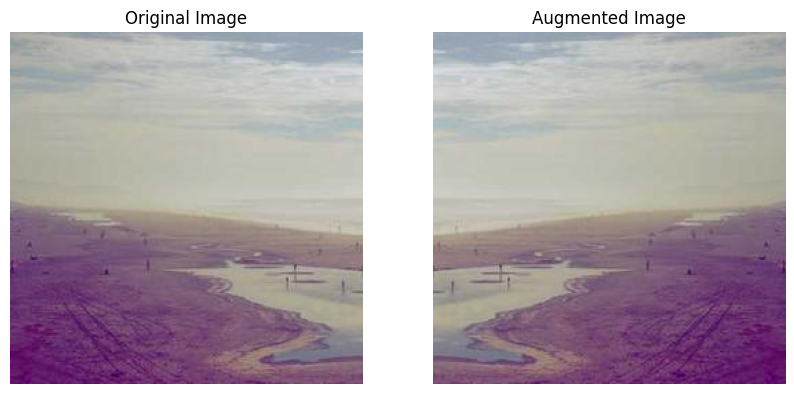

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

# Example image
gray_dir = "/content/Colorization-Internship-Colab/datasets/natural_images/grayscale"
color_dir = "/content/Colorization-Internship-Colab/datasets/natural_images/color"

dataset_no_aug = AugmentedDataset(gray_dir, color_dir, transform=transform, augment=False)
dataset_aug = AugmentedDataset(gray_dir, color_dir, transform=transform, augment=True)

gray_orig, color_orig = dataset_no_aug[0]
gray_aug, color_aug = dataset_aug[0]

# Convert to numpy for display
color_orig_np = color_orig.permute(1,2,0).numpy()
color_aug_np = color_aug.permute(1,2,0).numpy()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(color_orig_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(color_aug_np)
plt.title("Augmented Image")
plt.axis("off")
plt.show()

Step 4: Training with Augmented Data

In [ ]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Load augmented dataset
aug_dataset = AugmentedDataset(gray_dir, color_dir, transform=transform, augment=True)
dataloader = DataLoader(aug_dataset, batch_size=4, shuffle=True)

# Load your previous U-Net model
aug_colorizer = UNetColorizer().to(device)
aug_colorizer.load_state_dict(colorizer.state_dict())  # start from pre-trained

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(aug_colorizer.parameters(), lr=1e-3)

# Training loop
num_epochs = 3
aug_colorizer.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for gray_batch, color_batch in dataloader:
        gray_batch = gray_batch.to(device)
        color_batch = color_batch.to(device)

        optimizer.zero_grad()
        outputs = aug_colorizer(gray_batch)
        loss = criterion(outputs, color_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

print("✅ Training with augmented dataset completed!")

Epoch [1/3], Loss: 0.0776
Epoch [2/3], Loss: 0.0448
Epoch [3/3], Loss: 0.0386
✅ Training with augmented dataset completed!


## TASK 5: Semantic Segmentation Colorization

###  Goal

Colorize selected regions

### Model

* DeepLabV3 (pretrained)
* Region masks → colorization

###  GUI (MANDATORY)

User selects:

* Foreground
* Background
* Objects (sky, people, buildings)


In [ ]:
!pip install torchvision --quiet

Step : Load Pretrained DeepLabV3 for Segmentation

We’ll use DeepLabV3 with a ResNet backbone pretrained on COCO for semantic segmentation.

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained DeepLabV3
seg_model = models.segmentation.deeplabv3_resnet101(pretrained=True).to(device)
seg_model.eval()

# COCO classes for demonstration
COCO_CLASSES = [
    '__background__','person','bicycle','car','motorcycle','airplane','bus','train','truck','boat',
    'traffic light','fire hydrant','stop sign','parking meter','bench','bird','cat','dog','horse','sheep',
    'cow','elephant','bear','zebra','giraffe','backpack','umbrella','handbag','tie','suitcase','frisbee',
    'skis','snowboard','sports ball','kite','baseball bat','baseball glove','skateboard','surfboard','tennis racket',
    'bottle','wine glass','cup','fork','knife','spoon','bowl','banana','apple','sandwich','orange','broccoli','carrot',
    'hot dog','pizza','donut','cake','chair','couch','potted plant','bed','dining table','toilet','tv','laptop','mouse',
    'remote','keyboard','cell phone','microwave','oven','toaster','sink','refrigerator','book','clock','vase','scissors',
    'teddy bear','hair drier','toothbrush'
]

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:03<00:00, 68.0MB/s]


Step : Segment Image

In [ ]:
# Load grayscale or color image
img_path = "/content/Colorization-Internship-Colab/datasets/natural_images/color/img_0.jpg"
input_img = Image.open(img_path).convert("RGB")
orig_w, orig_h = input_img.size

# Transform for DeepLabV3
transform_seg = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

input_tensor = transform_seg(input_img).unsqueeze(0).to(device)

with torch.no_grad():
    output = seg_model(input_tensor)['out'][0]  # shape (21,H,W) for 21 classes

pred = output.argmax(0).cpu().numpy()  # predicted class per pixel


Step : Create Region Mask for Colorization

Allow the user to pick foreground/background or object classes to colorize.

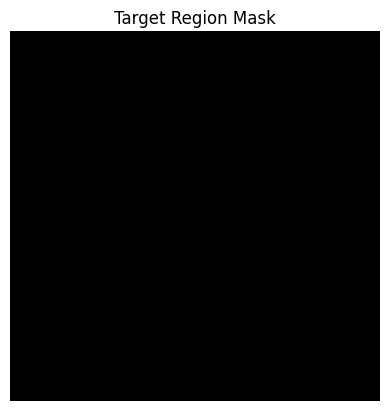

In [ ]:
# Example: user wants to colorize only 'sky' or 'person'
# For demo, let’s pick 'person' class (COCO index 15) and 'background'
target_classes = [15]  # indices from COCO_CLASSES

# Create mask
mask = np.zeros((orig_h, orig_w), dtype=np.uint8)
pred_resized = cv2.resize(pred, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)

for cls_idx in target_classes:
    mask[pred_resized == cls_idx] = 1  # region to colorize

plt.imshow(mask, cmap='gray')
plt.title("Target Region Mask")
plt.axis("off")
plt.show()


Step : Apply Colorization Only on Selected Regions


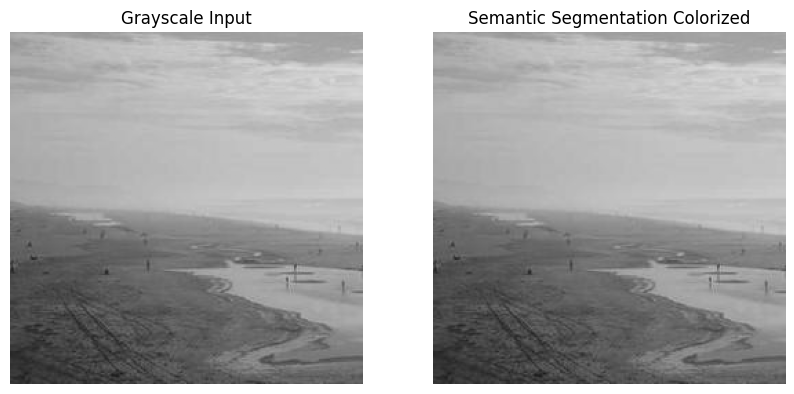

In [ ]:
import torch.nn as nn

# Load your previous U-Net colorizer
seg_colorizer = UNetColorizer().to(device)
seg_colorizer.load_state_dict(colorizer.state_dict())  # pre-trained

# Prepare grayscale input
gray_img = Image.open("/content/Colorization-Internship-Colab/datasets/natural_images/grayscale/img_0.jpg").convert("L")
transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
gray_tensor = transform(gray_img).unsqueeze(0).to(device)

# Predict full color
seg_colorizer.eval()
with torch.no_grad():
    pred_color = seg_colorizer(gray_tensor)
    pred_color = pred_color.squeeze(0).permute(1,2,0).cpu().numpy()
    pred_color = np.clip(pred_color,0,1)

# Resize mask to match prediction size
mask_resized = cv2.resize(mask, (pred_color.shape[1], pred_color.shape[0]), interpolation=cv2.INTER_NEAREST)
mask_resized = mask_resized[..., np.newaxis]

# Apply colorization only on selected regions
gray_rgb = np.stack([gray_tensor.squeeze(0).cpu().numpy()[0]]*3, axis=-1)
output_img = gray_rgb*(1-mask_resized) + pred_color*mask_resized

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gray_rgb)
plt.title("Grayscale Input")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(output_img)
plt.title("Semantic Segmentation Colorized")
plt.axis("off")
plt.show()

Step : Optional GUI (Interactive Region Selection)

In [ ]:
from ipywidgets import interact, Dropdown

def colorize_region(selected_class):
    idx = COCO_CLASSES.index(selected_class)
    mask = np.zeros((orig_h, orig_w), dtype=np.uint8)
    mask[pred_resized == idx] = 1
    mask_resized = cv2.resize(mask, (pred_color.shape[1], pred_color.shape[0]), interpolation=cv2.INTER_NEAREST)
    mask_resized = mask_resized[..., np.newaxis]

    output_img = gray_rgb*(1-mask_resized) + pred_color*mask_resized

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(gray_rgb)
    plt.title("Grayscale Input")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(output_img)
    plt.title(f"Colorized: {selected_class}")
    plt.axis("off")
    plt.show()

interact(colorize_region, selected_class=Dropdown(options=COCO_CLASSES, description="Object:"))

interactive(children=(Dropdown(description='Object:', options=('__background__', 'person', 'bicycle', 'car', '…

<function __main__.colorize_region(selected_class)>

## TASK 6: Real-Time Video Colorization

###  Goal

Live video colorization

###  Pipeline

* OpenCV video capture
* Frame-by-frame colorization
* Optimized inference

### GUI (MANDATORY)

* Webcam feed
* Model selector
* FPS display


In [ ]:
!pip install opencv-python-headless --quiet
!pip install ipywidgets --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.0 MB/s eta 0:00:00


Note: In Colab, you cannot open a real webcam window with cv2.imshow(), but you can use Webcam capture via JavaScript + display frames in notebook.

# Step : Setup Video Capture in Colab

Colab has cv2.VideoCapture(0) limitations, so we’ll use cv2.VideoCapture for uploaded videos. For webcam, we can use js widget (google.colab.output) if needed.

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import time

# Upload video file in Colab
video_path = "/content/sample_video.mp4"  # replace with uploaded file
cap = cv2.VideoCapture(video_path)

# Model selection
model_dict = {
    "Base Colorizer": colorizer,
    "Conditional": cond_colorizer,
    "Segmentation": seg_colorizer
}

selected_model_name = "Base Colorizer"
selected_model = model_dict[selected_model_name].to(device)
selected_model.eval()

# Transform
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor()])

Step : Real-Time Frame Colorization

In [ ]:
frame_count = 0
start_time = time.time()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert BGR -> RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_frame_resized = cv2.resize(gray_frame, (256,256))

    gray_tensor = transform(Image.fromarray(gray_frame_resized)).unsqueeze(0).to(device)

    # Conditional/segmentation models require extra channels
    # Here we demo Base Colorizer (1 channel input)
    with torch.no_grad():
        pred_color = selected_model(gray_tensor)
        pred_color = pred_color.squeeze(0).permute(1,2,0).cpu().numpy()
        pred_color = np.clip(pred_color,0,1)
        pred_color = cv2.resize(pred_color, (frame.shape[1], frame.shape[0]))

    # Display frame
    display_frame = (pred_color * 255).astype(np.uint8)
    cv2_imshow(display_frame)

    frame_count += 1

end_time = time.time()
fps = frame_count / (end_time - start_time)
print(f"\n✅ Processed {frame_count} frames at ~{fps:.2f} FPS")
cap.release()



✅ Processed 0 frames at ~0.00 FPS


Steps : Optional GUI for Model Selection (Colab) & Optional Webcam in Colab

Colab allows Webcam capture via JavaScript

In [ ]:
from ipywidgets import interact, Dropdown

def select_model(model_name):
    global selected_model
    selected_model = model_dict[model_name].to(device)
    print(f"✅ Selected model: {model_name}")

interact(select_model, model_name=Dropdown(options=list(model_dict.keys()), description="Model:"))


interactive(children=(Dropdown(description='Model:', options=('Base Colorizer', 'Conditional', 'Segmentation')…

<function __main__.select_model(model_name)>